## 知識情報学第9回演習サンプルプログラム ex9.ipynb
- Last updated: 2023/12/05
- Checked with Python 3.8.16, scikit-learn 1.3
- MIT License

## Wineデータに対するアンサンブル学習による識別
- 【課題2】アンサンブル数や木の最大深さを変更して，影響を考察しなさい．
  - ヒント: バギング系とブースティング系で傾向をまとめると良い

In [46]:
%matplotlib inline
from sklearn import datasets
import numpy as np
from sklearn.model_selection import cross_validate
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.inspection import DecisionBoundaryDisplay
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier


### Wineデータの読み込み

In [2]:
wine = datasets.load_wine()
print(wine.DESCR)

.. _wine_dataset:

Wine recognition dataset
------------------------

**Data Set Characteristics:**

    :Number of Instances: 178
    :Number of Attributes: 13 numeric, predictive attributes and the class
    :Attribute Information:
 		- Alcohol
 		- Malic acid
 		- Ash
		- Alcalinity of ash  
 		- Magnesium
		- Total phenols
 		- Flavanoids
 		- Nonflavanoid phenols
 		- Proanthocyanins
		- Color intensity
 		- Hue
 		- OD280/OD315 of diluted wines
 		- Proline

    - class:
            - class_0
            - class_1
            - class_2
		
    :Summary Statistics:
    
    ============================= ==== ===== ======= =====
                                   Min   Max   Mean     SD
    ============================= ==== ===== ======= =====
    Alcohol:                      11.0  14.8    13.0   0.8
    Malic Acid:                   0.74  5.80    2.34  1.12
    Ash:                          1.36  3.23    2.36  0.27
    Alcalinity of Ash:            10.6  30.0    19.5   3.3
    Ma

In [3]:
X = scale(wine.data)
y = wine.target

In [4]:
# PCAで2次元に圧縮
pca = PCA(n_components=2)
X_pca= pca.fit_transform(X)

### 決定木
- 課題1(a) 全データを用いて学習し，識別境界面とデータ点のプロットを行う
  - DecisionBoundaryDisplayを使用すると良い
     - sklearn v.1.1以上
- 課題1(b) クロスバリデーションを行い，学習データおよびテストデータに対する平均Accuracyを算出する

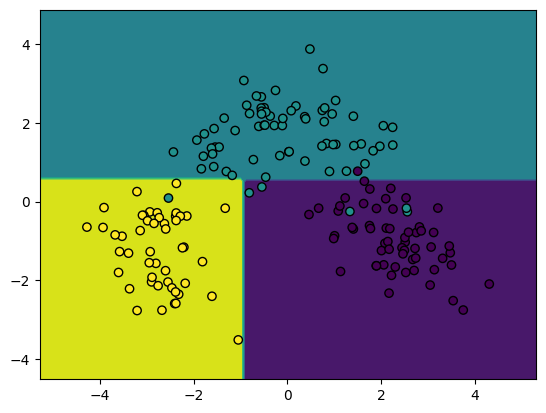

Average Training Accuracy: 0.9606754658385095
Average Test Accuracy: 0.9437908496732026


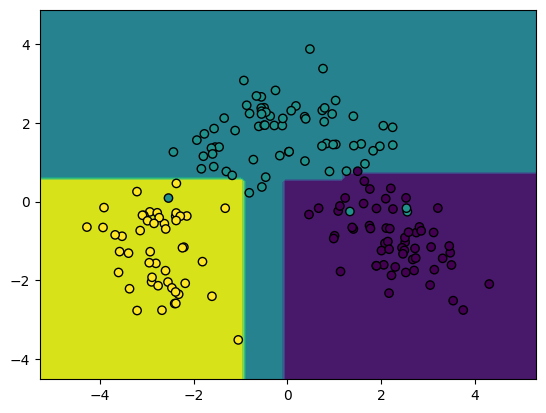

Average Training Accuracy: 0.9769021739130436
Average Test Accuracy: 0.9326797385620914


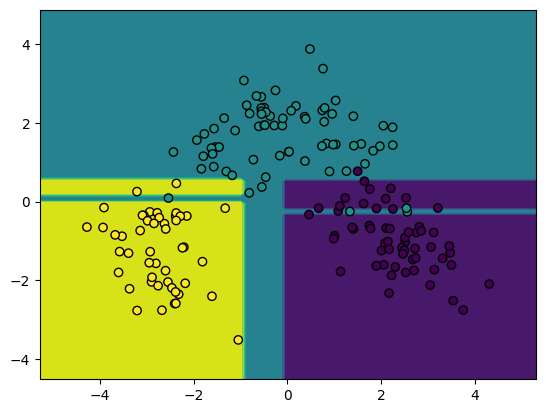

Average Training Accuracy: 0.9950038819875777
Average Test Accuracy: 0.9267973856209151


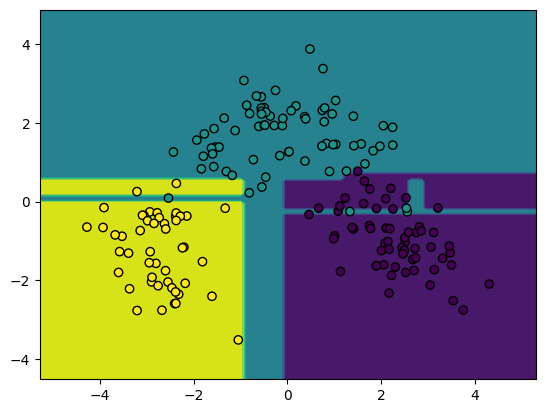

Average Training Accuracy: 1.0
Average Test Accuracy: 0.9267973856209151


In [50]:
# 決定木で分類して識別境界を表示
depth_list = [2, 3, 5, 10]
for depth in depth_list:
    clf = DecisionTreeClassifier(max_depth=depth)
    clf.fit(X_pca, y)

    display = DecisionBoundaryDisplay.from_estimator(clf, X_pca)
    display.ax_.scatter(X_pca[:, 0], X_pca[:, 1], c=y, edgecolor='k')
    plt.show()

    # クロスバリデーションで評価
    cv_results = cross_validate(clf, X_pca, y, cv=10, return_train_score=True)
    train_accuracy = cv_results['train_score'].mean()
    test_accuracy = cv_results['test_score'].mean()
    print("Average Training Accuracy:", train_accuracy)
    print("Average Test Accuracy:", test_accuracy)

#### 考察
- depthを深くするほど識別境界面が複雑になり、TrainingデータのAccuracyが高くなっているが、その分過学習が起きてTestデータのAccuracyは低下している

### Bagging
- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html
- 課題1 決定木同様に以降，全て実装する

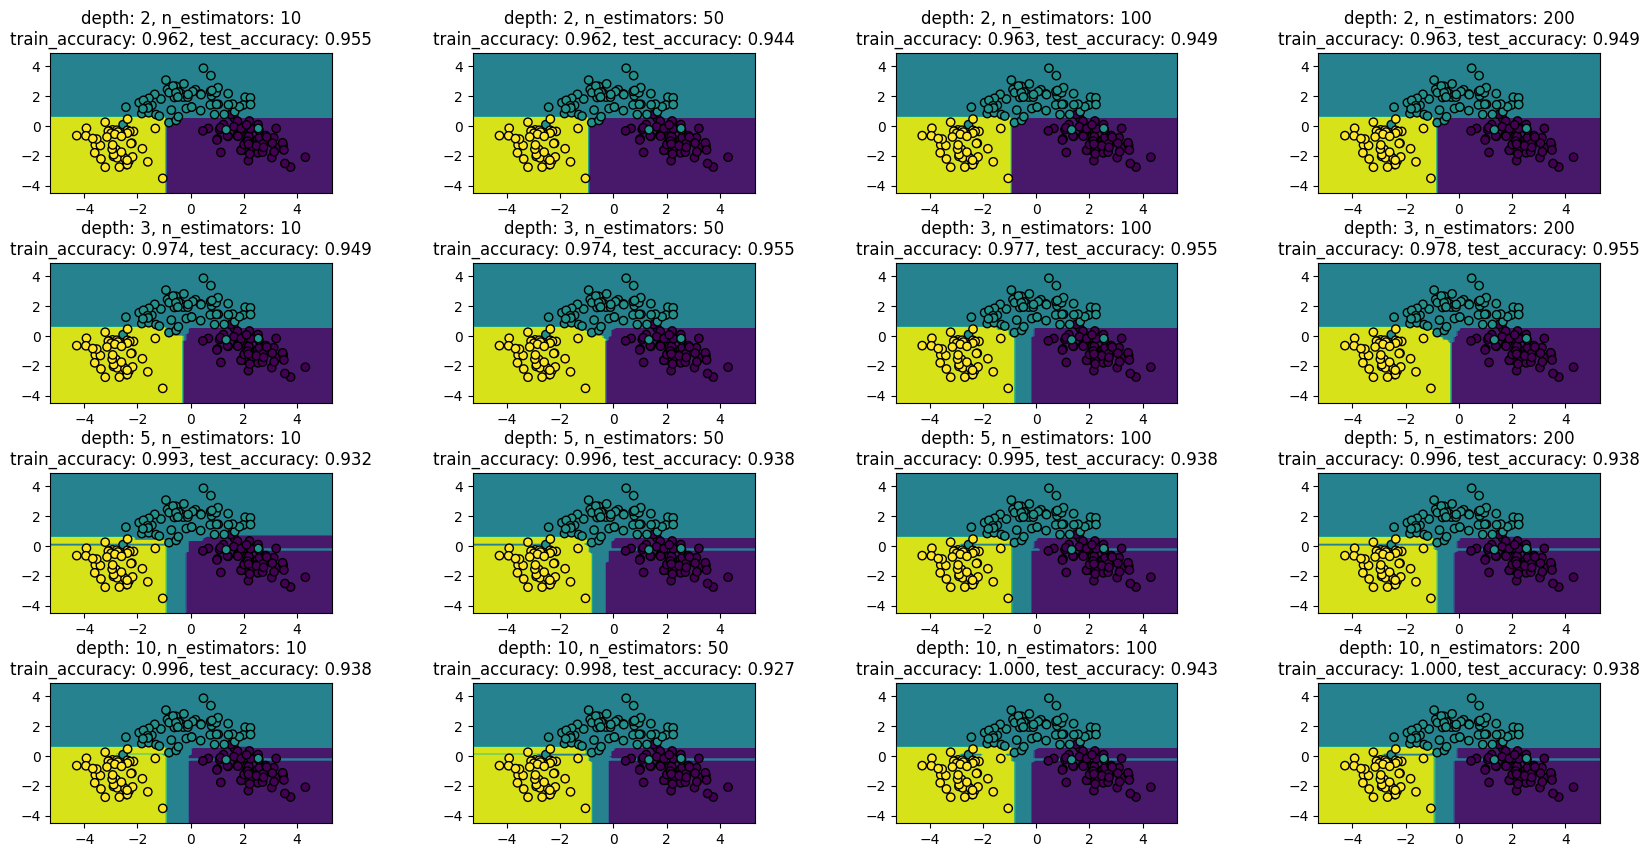

In [74]:
depth_list = [2, 3, 5, 10]
n_estimators_list = [10, 50, 100, 200]

fig, ax = plt.subplots(len(depth_list), len(n_estimators_list), figsize=(20, 10))
plt.subplots_adjust(wspace=0.5, hspace=0.5)

for i, depth in enumerate(depth_list):
    for j, n_estimators in enumerate(n_estimators_list):
        clf = BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=depth), n_estimators=n_estimators)
        
        cv_results = cross_validate(clf, X_pca, y, cv=10, return_train_score=True)
        train_accuracy = cv_results['train_score'].mean()
        test_accuracy = cv_results['test_score'].mean()
        
        clf.fit(X_pca, y)
        DecisionBoundaryDisplay.from_estimator(clf, X_pca, ax=ax[i, j])
        ax[i, j].scatter(X_pca[:, 0], X_pca[:, 1], c=y, edgecolor='k')
        ax[i, j].set_title(f"depth: {depth}, n_estimators: {n_estimators}\ntrain_accuracy: {train_accuracy:.3f}, test_accuracy: {test_accuracy:.3f}")
        

#### 考察
- depthを深くするほどtrainingデータへの適合度が高くなりtrain_accuracyは改善するが、過学習が起きてtest_accuracyは低下している
- n_estimatorsを増やすとtrain, testともにaccuracyが改善している
- 実験した範囲ではdepth=3, n_estimators=50, 100, 200で最もtest_accuracyが高くなった。バギングではバリアンスの高い識別器を多数重ねることで精度が向上することを考えると予測器のdepthが深い方が良いと予想していたが、多くの予測器が同様の過学習を起こしたことでむしろ精度が低下しているのだと考えられる。

### Random Forest
- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

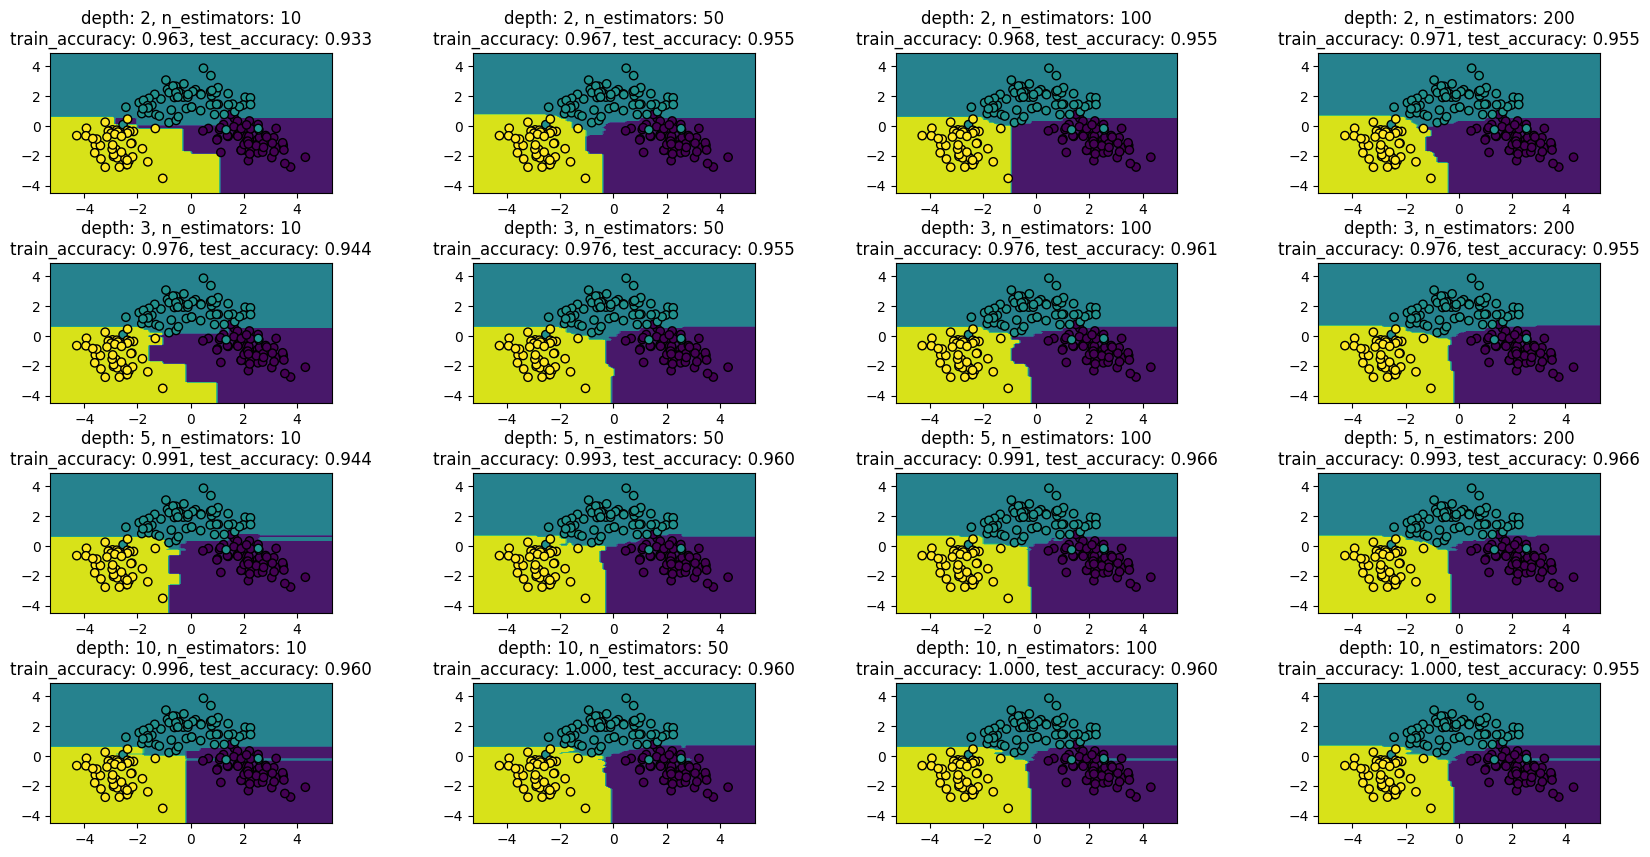

In [75]:
depth_list = [2, 3, 5, 10]
n_estimators_list = [10, 50, 100, 200]

fig, ax = plt.subplots(len(depth_list), len(n_estimators_list), figsize=(20, 10))
plt.subplots_adjust(wspace=0.5, hspace=0.5)

for i, depth in enumerate(depth_list):
    for j, n_estimators in enumerate(n_estimators_list):
        clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=depth)
        
        cv_results = cross_validate(clf, X_pca, y, cv=10, return_train_score=True)
        train_accuracy = cv_results['train_score'].mean()
        test_accuracy = cv_results['test_score'].mean()
        
        clf.fit(X_pca, y)
        DecisionBoundaryDisplay.from_estimator(clf, X_pca, ax=ax[i, j])
        ax[i, j].scatter(X_pca[:, 0], X_pca[:, 1], c=y, edgecolor='k')
        ax[i, j].set_title(f"depth: {depth}, n_estimators: {n_estimators}\ntrain_accuracy: {train_accuracy:.3f}, test_accuracy: {test_accuracy:.3f}")
        

#### 考察
- RandamForestでもバギングと同様の結果が得られた
- depth=5, n_estimators=100, 200で最も良いtest_accuracyが得られた。特徴量をランダムに選んでいることにより弱予測器ごとの独立性が増してバギングより精度が向上している。
- depthが同じ場合でもバギングより弱予測器ごとの独立性が得られるため、バギングよりも深いdepthで良い結果が得られていると考えられる。

### AdaBoost
- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html
- scikit-learnのAdaBoostClassifierは，デフォルトのbase_estimatorがDecisionTreeClassifier(max_depth=1)のため注意

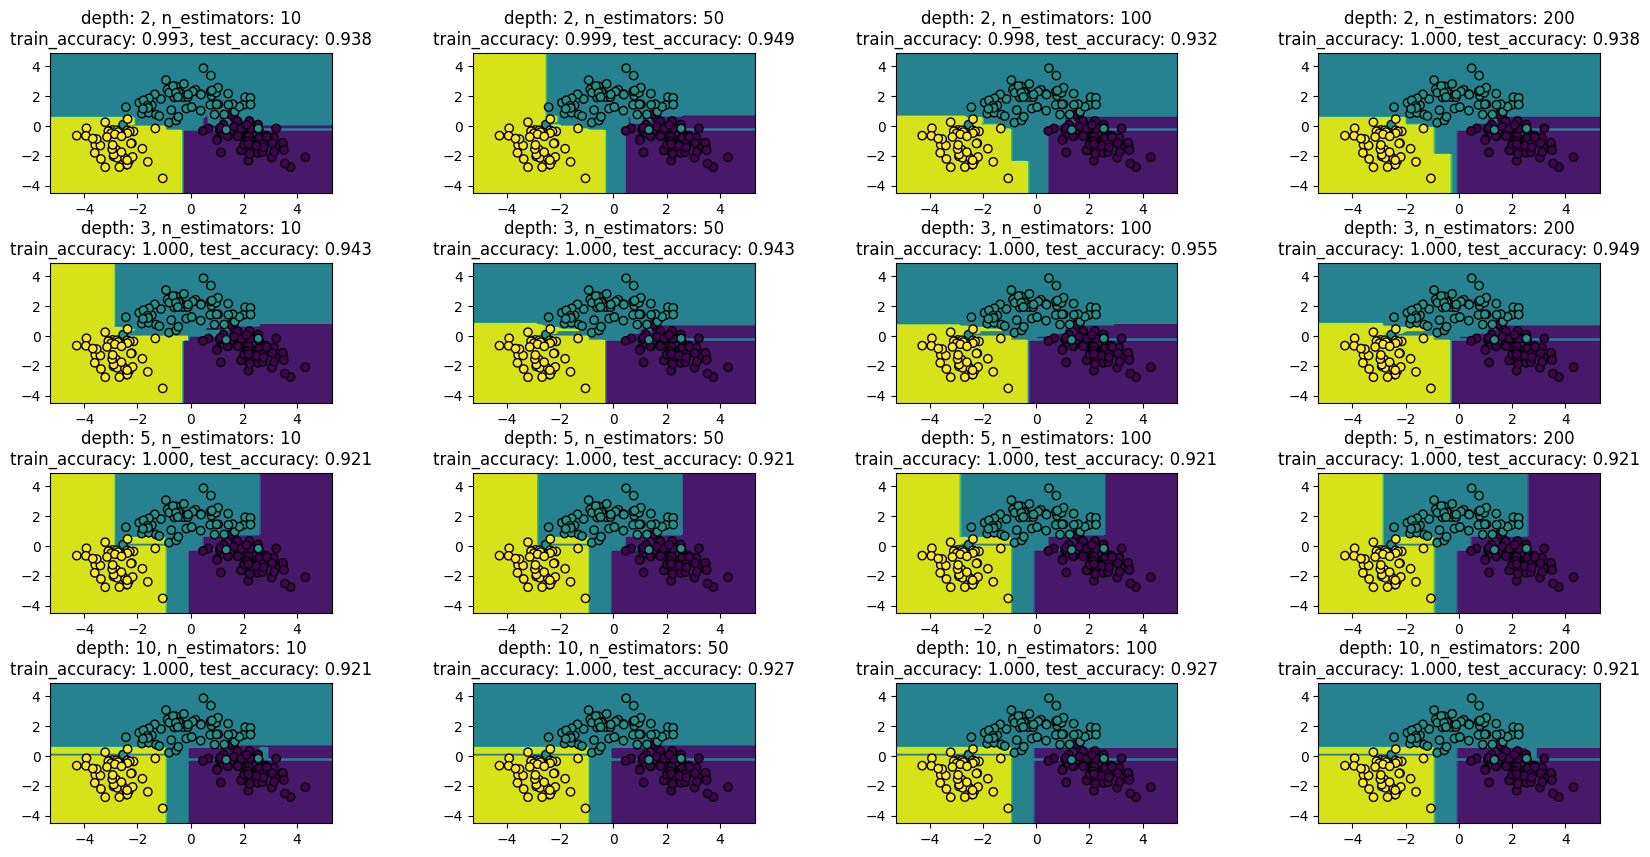

In [76]:
depth_list = [2, 3, 5, 10]
n_estimators_list = [10, 50, 100, 200]

fig, ax = plt.subplots(len(depth_list), len(n_estimators_list), figsize=(20, 10))
plt.subplots_adjust(wspace=0.5, hspace=0.5)

for i, depth in enumerate(depth_list):
    for j, n_estimators in enumerate(n_estimators_list):
        clf = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=depth), n_estimators=n_estimators)
        
        cv_results = cross_validate(clf, X_pca, y, cv=10, return_train_score=True)
        train_accuracy = cv_results['train_score'].mean()
        test_accuracy = cv_results['test_score'].mean()
        
        clf.fit(X_pca, y)
        DecisionBoundaryDisplay.from_estimator(clf, X_pca, ax=ax[i, j])
        ax[i, j].scatter(X_pca[:, 0], X_pca[:, 1], c=y, edgecolor='k')
        ax[i, j].set_title(f"depth: {depth}, n_estimators: {n_estimators}\ntrain_accuracy: {train_accuracy:.3f}, test_accuracy: {test_accuracy:.3f}")
        

### Gradient Boosting
- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html

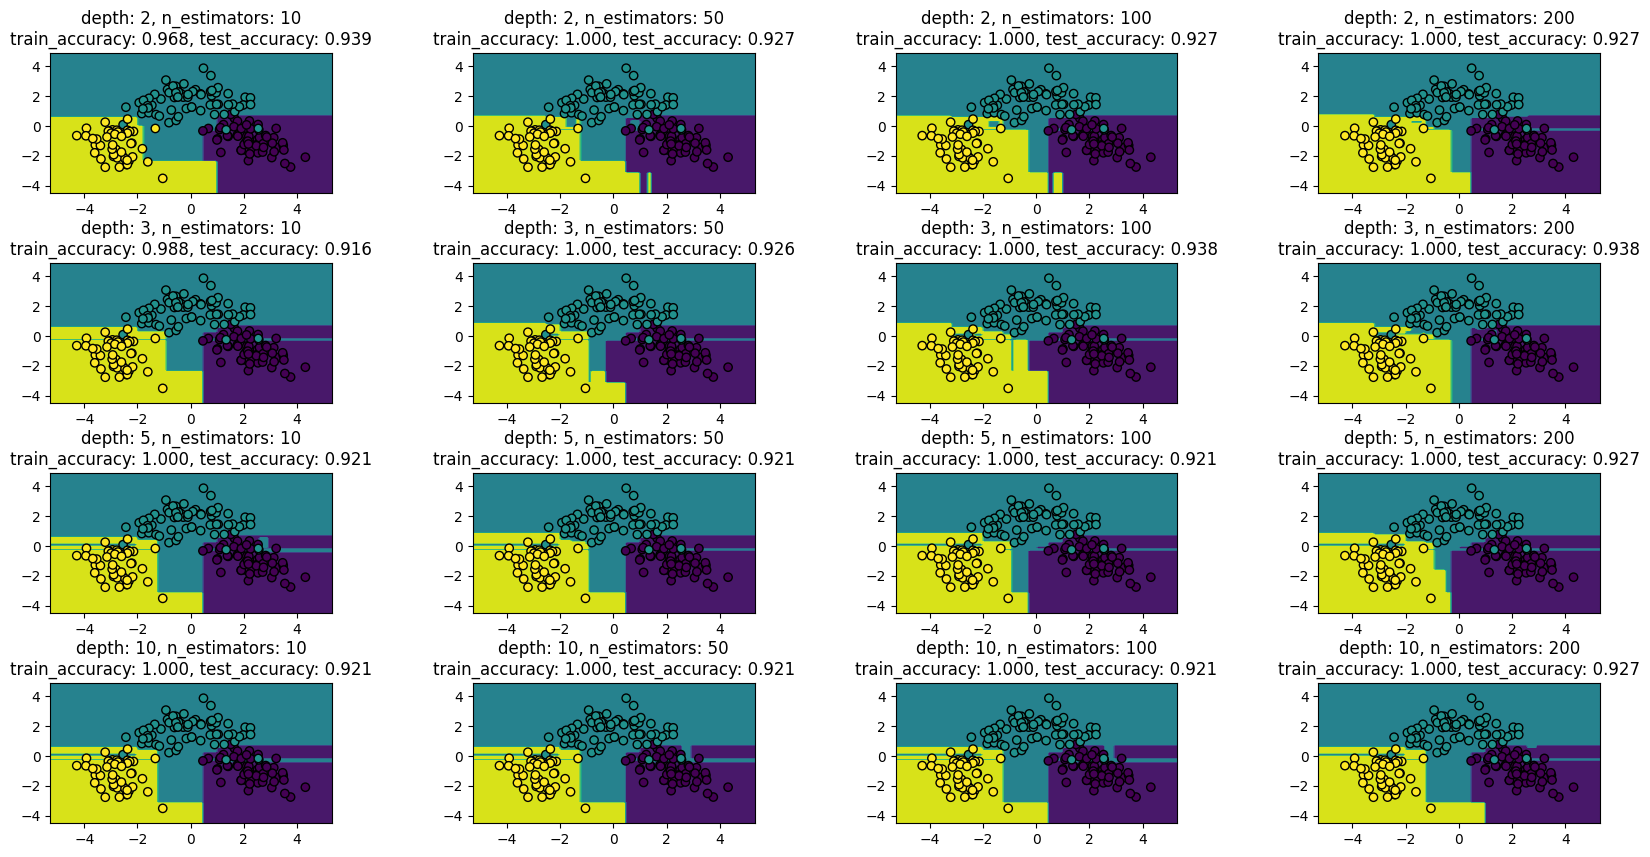

In [77]:
depth_list = [2, 3, 5, 10]
n_estimators_list = [10, 50, 100, 200]

fig, ax = plt.subplots(len(depth_list), len(n_estimators_list), figsize=(20, 10))
plt.subplots_adjust(wspace=0.5, hspace=0.5)

for i, depth in enumerate(depth_list):
    for j, n_estimators in enumerate(n_estimators_list):
        clf = GradientBoostingClassifier(n_estimators=n_estimators, max_depth=depth)
        
        cv_results = cross_validate(clf, X_pca, y, cv=10, return_train_score=True)
        train_accuracy = cv_results['train_score'].mean()
        test_accuracy = cv_results['test_score'].mean()
        
        clf.fit(X_pca, y)
        DecisionBoundaryDisplay.from_estimator(clf, X_pca, ax=ax[i, j])
        ax[i, j].scatter(X_pca[:, 0], X_pca[:, 1], c=y, edgecolor='k')
        ax[i, j].set_title(f"depth: {depth}, n_estimators: {n_estimators}\ntrain_accuracy: {train_accuracy:.3f}, test_accuracy: {test_accuracy:.3f}")
        

#### 考察
- boosting系手法は過学習によりあまり良い結果が得られなかった。ADABOOSTではdepth=3, n_estimators=100で最も良いtest_accuracyを示したが、識別境界面が複雑になっており、train_accuracyも1であることから過学習していることが見て取れる。
- 今回扱ったデータはシンプルな識別境界面を持っていたが、識別境界面がより複雑なデータや特徴量が多いデータではboostring系手法の優位性が現れる可能性があると思われる。